In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# change current working directory to the root of the project
import os
os.chdir(os.path.dirname(os.getcwd()))

In [16]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/var/folders/rx/jl4f7yr95xd03cgb4sg2w99h0000gn/T/ipykernel_21596/4075833985.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Purpose
- Purpose of this notebook is to determine the optimal threshold to produce labels by maximizing G-Mean

In [3]:
from IPython.display import display
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from numpy import argmax

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# Load Data

In [4]:
nrows = None

X_val_threshold = pd.read_csv("data/transformed/X_val_threshold.csv", nrows=nrows)
X_test = pd.read_csv("data/transformed/X_test.csv", nrows=nrows)

y_val_threshold = pd.read_csv("data/transformed/y_val_threshold.csv", nrows=nrows)
y_test = pd.read_csv("data/transformed/y_test.csv", nrows=nrows)

# Load the model and predict


In [5]:
# load model
calibrated_model = joblib.load('models/calibrated_lightgbm.pkl')

# predict on validation set
y_val_threshold['pred_proba'] = calibrated_model.predict_proba(X_val_threshold)[:, 1]

# predict on test set
y_test['pred_proba'] = calibrated_model.predict_proba(X_test)[:, 1]

In [9]:
# compute brier score on validation set
brier_score = metrics.brier_score_loss(y_val_threshold['target'], y_val_threshold['pred_proba'])
print(f"Brier score: {brier_score:.4f}")

Brier score: 0.0699


# Determine Optimal Threshold
- Determine optimal threshold using validation set
- Calculate ROC
- Determine Optimal Threshold by Maximizing G-Mean

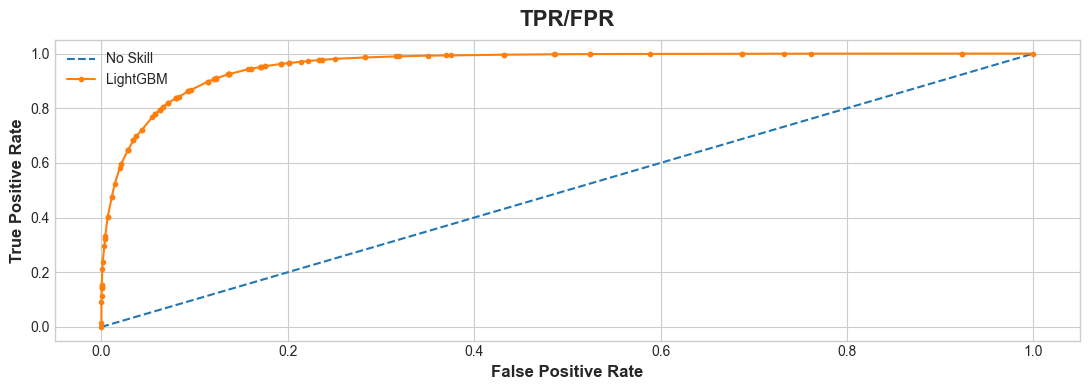

In [17]:
# Calculate ROC Scores
fpr, tpr, thresholds = roc_curve(y_val_threshold['target'], y_val_threshold['pred_proba'])

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')

# axis labels
plt.title('TPR/FPR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()

Best Threshold=0.261559, G-Mean=0.894


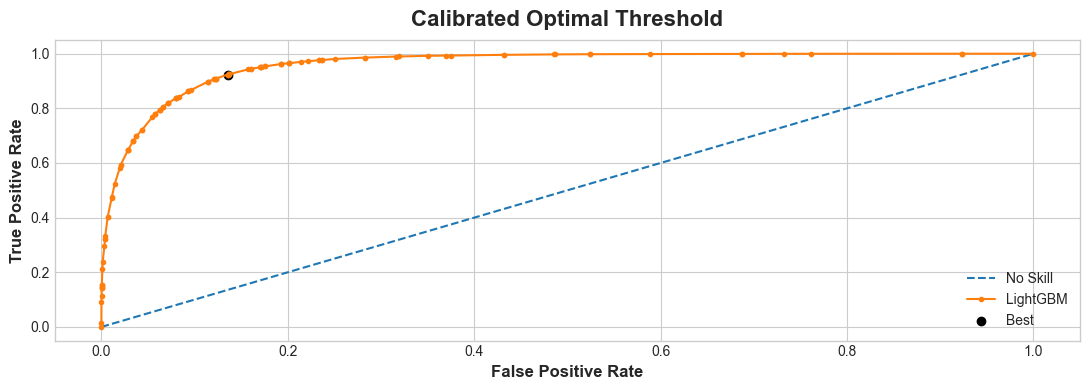

In [18]:
# Determine optimal Threshold by Maximizing G-Mean - calibrated
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# axis labels
plt.title("Calibrated Optimal Threshold")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()

# Confusion Matrix 

In [19]:
# calibrated
optimal_threshold = thresholds[ix]
preds = pd.DataFrame({'preds': y_test['pred_proba'], 'y_test': y_test['target']})

conditions = [
    (preds['preds'] >= optimal_threshold),
    (preds['preds'] < optimal_threshold)]
values = [1, 0]

preds['labels'] = np.select(conditions, values, default=None)
preds['y_test'] = preds['y_test'].astype(int)
preds['labels'] = preds['labels'].astype(int)

display(preds)

,preds,y_test,labels
0,0.022497,0,0
1,0.564356,1,1
2,0.070000,0,0
3,0.000000,0,0
4,0.000674,0,0
...,...,...,...
91778,0.007179,0,0
91779,0.419421,0,1
91780,0.003382,0,0
91781,0.001543,0,0


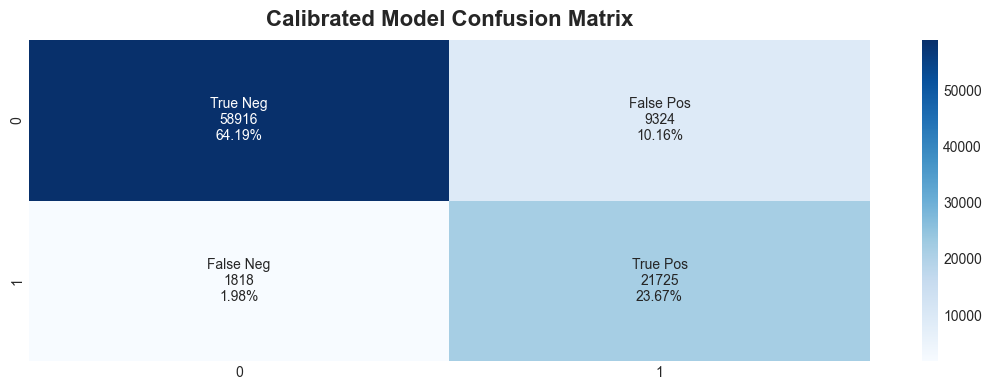

In [20]:
cf_matrix = confusion_matrix(preds['y_test'], preds['labels'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_cots = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_cots,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.title('Calibrated Model Confusion Matrix')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.tight_layout()